In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis

In [2]:
def PT(phi,X):
    Y=np.random.poisson(phi,X)
    L=sum(Y)
    return L

In [3]:
def INHAR_P(hps,phis,n):
    X0=list(np.random.poisson(phis[-1],hps[-1]))
    for t in range(hps[-1],n):
        order,Y=[],[]
        for i in hps:
            globals()['Xt_{}'.format(i)] = int(np.mean(X0[t-i:t]))
            order.append(globals()['Xt_{}'.format(i)])
        for i in range(len(hps)):
            Xt=PT(phis[i],order[i])
            Y.append(Xt)
        ram=np.random.poisson(phis[-1])
        Y=sum(Y)+ram
        X0.append(Y)
    return X0

In [4]:
def CLSE(XX,hps):
    nn,n=len(XX),len(hps)
    for i in range(n+1):
        globals()['b_'+str(i)] = 0
    A=np.zeros((n+1,n+1))
    for t in range(nn-hps[-1]):
        Xt=XX[t+hps[-1]]
        Xtt=[]
        for i in hps:
            globals()['Xt_'+str(i)] = int(np.mean(XX[t+hps[-1]-i : t+hps[-1]]))
            Xtt.append(globals()['Xt_'+str(i)])
        Xtt.append(1)
        for i in range(n+1):
            globals()['b_'+str(i)] = globals()['b_'+str(i)] + Xt*Xtt[i]
            for j in range(n+1):
                A[i,j]=A[i,j]+Xtt[i]*Xtt[j]
    b=[]
    for i in range(n+1):
        b.append(globals()['b_'+str(i)])
    A_inv=np.linalg.inv(A)
    return np.matmul(A_inv,b)

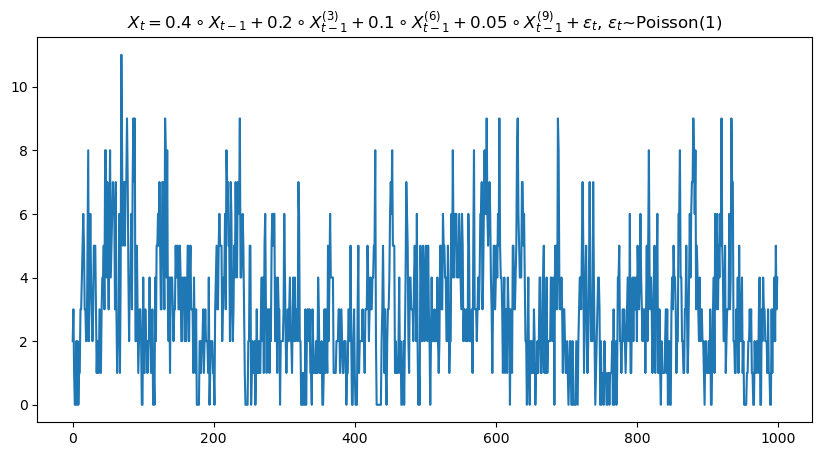

In [5]:
hps=[1,3,6,9]
params=[0.4,0.2,0.1,0.05,1]
inhar3=INHAR_P(hps,params,1000)

plt.figure(figsize=(10,5))
plt.title("$X_t=0.4\circ X_{t-1}+0.2\circ X_{t-1}^{(3)}+0.1\circ X_{t-1}^{(6)}+0.05\circ X_{t-1}^{(9)}+\epsilon_t$, $\epsilon_t$~Poisson(1)")
plt.plot(inhar3);

# EDA

In [6]:
ipo=pd.read_excel('ipo.xlsx',engine='openpyxl',skiprows=[0,1])
ipo.set_index('period',inplace=True)
ipo.drop(ipo.tail(1).index,inplace=True)

In [7]:
L=[]
for _ in range(23):
    L.extend(list(ipo.iloc[:,22-_]))
L=L[:-5]
Date=pd.date_range("2000-1","2022-7",freq="MS")

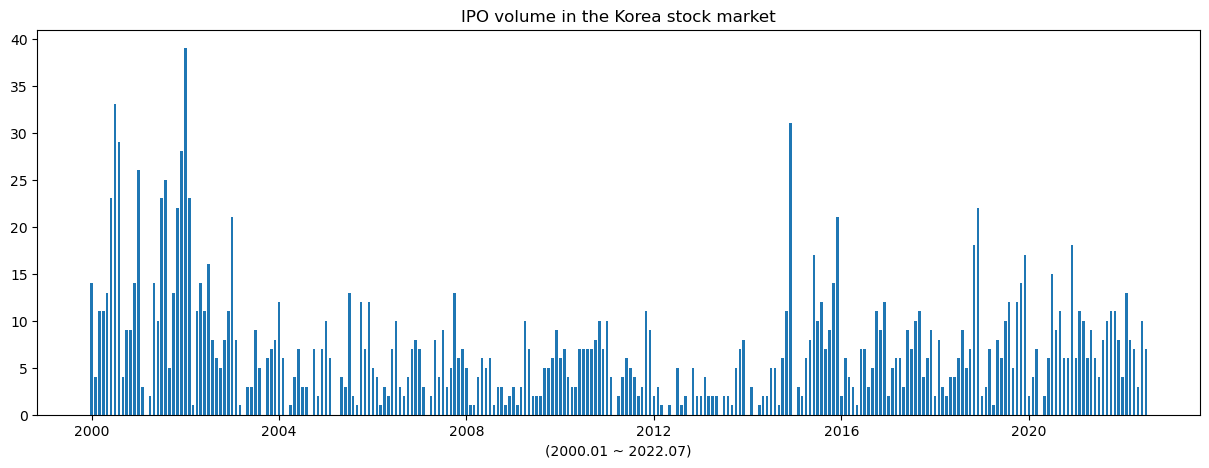

In [8]:
plt.figure(figsize=(15,5))
plt.title("IPO volume in the Korea stock market")
plt.xlabel("(2000.01 ~ 2022.07)")
plt.bar(Date,L,width=20);

In [9]:
pd.DataFrame(L).describe().round(4)

,0
count,271.0000
mean,6.8303
std,6.1035
min,0.0000
25%,3.0000
50%,6.0000
75%,9.0000
max,39.0000


In [10]:
result=adfuller(L)
print('ADF statistics: %f' % result[0])
print('p-value: %f' % result[1])
round(skew(L),4),round(kurtosis(L, fisher=True),4)

ADF statistics: -2.914398
p-value: 0.043699


(1.985, 5.4079)

# Fitting

In [11]:
def INHAR_P(DATA,args):
    X=DATA
    n=len(X)
    Y,XX=[],[]
    for t in range(args[len(args)-1],n):
        Xt=X[t]
        order=[]
        for i in args:
            globals()['Xt_'+str(i)] = int(np.mean(X[t-i:t]))
            order.append(globals()['Xt_'+str(i)])
        order.append(1)
        XX.append(order)
        Y.append(Xt)
    return XX,Y

In [12]:
p=[1,12]
X,Y=INHAR_P(L,p)
model=sm.OLS(Y,X)
results=model.fit()

In [13]:
results.params

array([0.32251446, 0.43924204, 1.64920929])

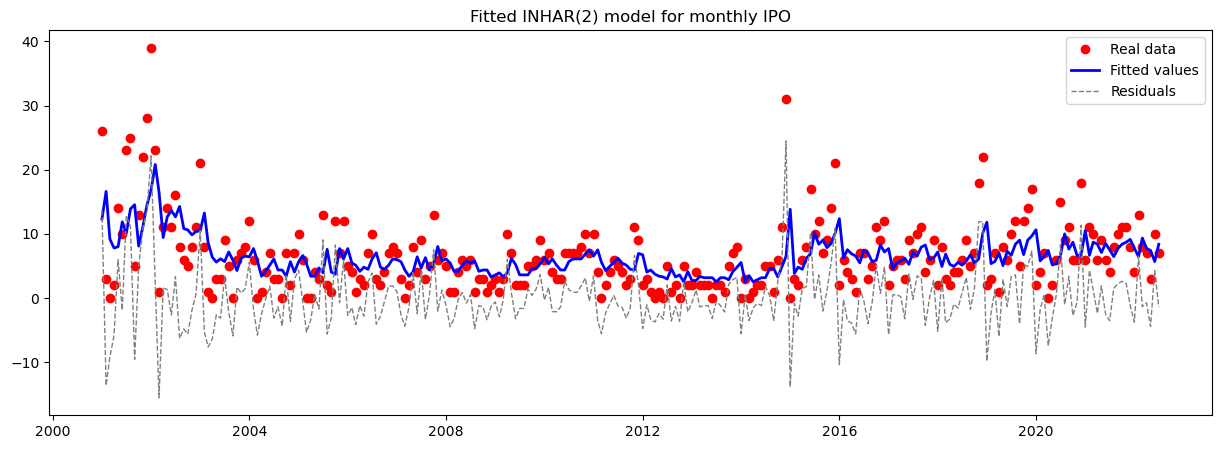

In [14]:
st=p[-1]
plt.figure(figsize=(15,5))
plt.title(f"Fitted INHAR({len(p)}) model for monthly IPO")
plt.plot(Date[st:],L[st:],color='r',linewidth=0,label="Real data",marker='o')
plt.plot(Date[st:],results.fittedvalues,color='b',linewidth=2,label="Fitted values")
plt.plot(Date[st:],L[st:]-results.fittedvalues,color='grey',linestyle='dashed',linewidth=1,label="Residuals")
plt.legend();

# Forecasting

In [15]:
def INHAR_FORE(DATA,m,n,p):
    Lf,Lf_cl,Lf_cu=[],[],[]

    for i in range(n):
        X,Y=INHAR_P(L[-m+i:-n+i],p)
        model=sm.OLS(Y,X)
        results=model.fit()
        clse=results.params
        clse_cl=np.array([results.conf_int()[_][0] for _ in range(len(p)+1)])
        clse_cu=np.array([results.conf_int()[_][1] for _ in range(len(p)+1)])
        xx=X[-1]
        y,y_cl,y_cu=sum(clse*xx),sum(clse_cl*xx),sum(clse_cu*xx)
        Lf.append(y)
        Lf_cl.append(y_cl)
        Lf_cu.append(y_cu)

    res=np.array(Lf)-L[-n:]
    inhar_res=[sum(abs(res))/len(res),
               np.sqrt(sum(res**2)/len(res)),
               sum(abs(res/L[-n:]))*100/len(res),
               sum(abs(res)/(L[-n:]+abs(np.array(Lf))))*100/len(res),
               np.sqrt(sum(res**2)/sum((np.mean(L[-n:])-L[-n:])**2))]
    return inhar_res

In [16]:
p=[1,12]
N,n=len(L),19

Lf,Lf_cl,Lf_cu=[],[],[]

for i in range(n):
    X,Y=INHAR_P(L[i:i+N-n],p)
    model=sm.OLS(Y,X)
    results=model.fit()
    clse=results.params
    clse_cl=np.array([results.conf_int()[_][0] for _ in range(len(p)+1)])
    clse_cu=np.array([results.conf_int()[_][1] for _ in range(len(p)+1)])
    xx=X[-1]
    y,y_cl,y_cu=sum(clse*xx),sum(clse_cl*xx),sum(clse_cu*xx)
    Lf.append(y)
    Lf_cl.append(y_cl)
    Lf_cu.append(y_cu)
    
res=np.array(Lf)-L[-n:]
inhar_res=[sum(abs(res))/len(res),
           np.sqrt(sum(res**2)/len(res)),
           sum(abs(res/L[-n:]))*100/len(res),
           sum(abs(res)/(L[-n:]+abs(np.array(Lf))))*100/len(res),
           np.sqrt(sum(res**2)/sum((np.mean(L[-n:])-L[-n:])**2))]

print("error:",np.round(inhar_res,4))    

error: [ 2.4699  2.9643 39.1116 16.5429  1.108 ]


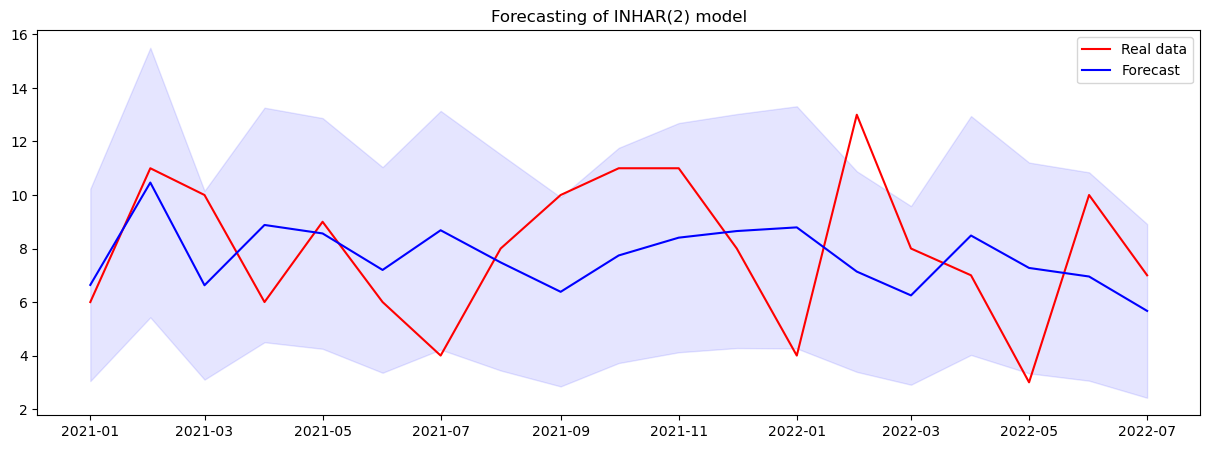

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title(f"Forecasting of INHAR({len(p)}) model")
ax.plot(Date[-n:],L[-n:],label="Real data",color='r')
ax.plot(Date[-n:],Lf,label="Forecast",color='b')
ax.fill_between(Date[-n:],Lf_cl,Lf_cu, color='b', alpha=.1)
plt.legend();